# ML Lab 2: Part 2 [30 Marks]
In this part we will be classifying the same data used in part 1, but with a convolutional neural network. Previously you had to flatten the images to 1D vectors, which breaks down important spatial structures. You could use 1D convolutions neural networks, however, it makes sense to preserve the 2D stucture to begin with. 

**TIP:** Watch the CNN example videos for guidance :)

| Task \# |Total marks |Grade|
| :------:|:----------:|:---:|
|1|4||
|2|2||
|3|3||
|4|6||
|5|6||
|6|6||
|7|3||

In [63]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import SubsetRandomSampler
from PIL import Image

In [64]:
BATCH_SIZE = 32
MAX_EPOCHS = 25

Here we will use the same radar data as part 1. The $15^\circ$ and $17^\circ$ training sets have been combined here as well. 

In [65]:
#dataset_dir = Path.cwd().parent.parent / "datasets" #or wherever your dataset is located
#dataset_dir = Path.cwd().parent.parent / "Downloads"/"Dsp_Lab2" #or wherever your dataset is located

#x_15_train = np.load(dataset_dir / "radar_data_npy" / "train"/ "input_15_train.npy")
#y_15_train = np.load(dataset_dir / "radar_data_npy" / "train"/ "label_15_train.npy")
#x_17_train = np.load(dataset_dir / "radar_data_npy" / "train"/ "input_17_train.npy")
#y_17_train = np.load(dataset_dir / "radar_data_npy" / "train"/ "label_17_train.npy") 
x_15_train = np.load(Path.cwd() / "radar_data_npy" / "input_15_train.npy")
y_15_train = np.load(Path.cwd()  / "radar_data_npy" / "label_15_train.npy")
x_17_train = np.load(Path.cwd()  / "radar_data_npy" / "input_17_train.npy")
y_17_train = np.load(Path.cwd()  / "radar_data_npy" / "label_17_train.npy")

x_train = np.concatenate((x_15_train, x_17_train))
y_train = np.concatenate((y_15_train, y_17_train))

# Task 1: Splitting your data [4 marks]

Split your data using one of the resampling methods covered in lectures, you can make use of the sklearn `train_test_split()` function. 

In [66]:
# TASK 1 CODE HERE [2 marks]

### BEGIN ANSWER ###
# You can do whatever you would like to as long as it works with the rest of your code later on.
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1)
### END ANSWER ###

### Question [2 marks]: 

Explain your decision in task 1 e.g. what are some of the benefits of your chosen resampling method, what are some potential downsides, and why you think it is appropriate for the given task.  

### Answer:
Split into training and validation set.

benefit- Using the same dataset for training and testing can cause miscalculations inaccurate prediction,therefore this function helps us split the data so we have a better chance of the data being valid and accurate.

downside- Testing data is not used for training , so if the function are not set up properly it can cause undefitting or overfitting.

appropriateness- It is appropriate here because we dont have many datasets.

# Custom Dataset
Libraries such as Pytorch offer mechanisms for efficiently loading data during training and evaluation. Here is a custom dataloader for the radar dataset.

We could use these datasets and dataloaders to perform transformations on the data on-the-fly rather than making the modifications on the entire dataset beforehand. 

Unlike part 1 we are not going to one-hot encode the labels, instead the loss function we will use in Pytorch assumes that each class is represented by an interger value, and will do any other transformations internally. 

The code below is used to create easier to use datasets. No need to worry about how it works, just that it will help make loading data much easier later.

In [67]:
class MSTAR(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.transform = transform
        self.enc = LabelEncoder()
        targets = self.enc.fit_transform(targets.reshape(-1,))
        self.targets = torch.LongTensor(targets)
        
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = int(index.item())
            
        x = self.data[index]
        y = self.targets[index]

        if self.transform:
            x = Image.fromarray(self.data[index])
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

# Task 2: Data scaling [2 marks]

Scale the input data appropriately. You can scale it between 0 and 1, just as with part 1 (use the code provided in part1 to help you with the use of the scaling functions) or you could use standardisation with the `StandardScaler` if you want to. 

In [68]:
# TASK 2 CODE HERE [2 marks]

### BEGIN ANSWER ###
# You can do whatever you would like to as long as it works with the rest of your code later on.
scaler = MinMaxScaler()
x_train_shape = x_train.shape
x_val_shape = x_val.shape

# fit scaler on training data, and transform it as well
x_train = scaler.fit_transform(x_train.reshape(-1, 1))
x_train = x_train.reshape(x_train_shape)

# only transform sets used for evaluation 
x_val = scaler.transform(x_val.reshape(-1, 1))
x_val = x_val.reshape(x_val_shape)

### END ANSWER ###

# Task 3: Setup Dataloaders [3 marks]
Once you have defined a dataset you can use dataloaders that will feed the data to the model. There are various sampling strategies you could apply as well, but seeing as we have already split the data we can stick to the default samplers. 

In [69]:
# TASK 3 CODE HERE [3 marks]

transform = transforms.Compose(
    [
     transforms.ToTensor()
    ])

### BEGIN ANSWER ###

# You can do whatever you would like to as long as it works with the rest of your code later on.
# define datasets
# e.g. train_dataset = MSTAR(x_train, y_train, transform=transform)
train_dataset = MSTAR(x_train, y_train, transform=transform)
val_dataset = MSTAR(x_val, y_val, transform=transform)

# define dataloaders from the datasets(make sure you define a BATCH_SIZE to use)
# e.g. train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
train_loader = DataLoader(train_dataset, batch_size=32)
# The amount of evaluation data could be loaded in all at once. You could also provided batches if these sets were very large 
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset))

### END ANSWER ###

# Task 4: Defining the architecture [6 marks]

Define your own neural network architecture that you think would do well to classify the targets. You do not need to perform a hyperparameter search, as it may take up a lot of time depending on your computational resources. You could opt to use something like [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb?utm_source=scs-index#) if you want free GPU access, but it is not necessary.


## Some useful Pytorch functions:

torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros') ([docs](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html?highlight=conv2d#torch.nn.Conv2d))\
torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False) ([docs](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html?highlight=maxpool2d#torch.nn.MaxPool2d))\
torch.nn.Linear(in_features, out_features, bias=True) ([docs](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=linear#torch.nn.Linear))



### Question [2 marks]:
Describe your architecture, for example, how many feature maps are there in each layer, what is the shape of each layer etc.

### Answer:
Essentially a copy of the structure used in one the LeNet-5 paper, but the sizes are modified to suit the task

-First we have input of 6, 5x5 kernels applied to single channel, 54x54 input.
-This gives 6 feauture maps of sixe 50x50 (Result of cross-correlating with 5x5 kernel)
-Then we do 2x2 max pooling. What is left is 6 feautere maps of size 25x25.
-Another convolution layer is then done on top of this . This time we use 16, 5x5 kernels, applied to 6 channel 25x25 , input.
-Then we add up convolution values giving 16 feature maps of size 20x20(Result of cross-correlating with 5x5 kernel)
-Once again 2x2 max pooling resulting in 16 feature maps of size 10x10.
-Lastly flatten the neurons so we have 16x10x10 acting as our input layer going to the feed forward network.
-so we have 120 hidden neurons connected
-and 8 output neurons to match 8 target classes

In [70]:
# TASK 4 CODE HERE [4 marks]
# You can also change this to use the Pytorch Sequential Model style

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # data has a single input channel
        # Pytorch does valid padding by default.
        # You would define your layers here with whatever parameters you choose e.g.
        # self.conv1 = nn.Conv2d()
        # self.pool = nn.MaxPool2d()        
        # self.fc1 = nn.Linear()
        self.conv1 = nn.Conv2d(1, 6, 5)
        
                
        # 2x2 max-pooling 
        self.pool = nn.MaxPool2d(2, 2)        
        # 6, 25x25 feature maps going out of the pooling stage 
        
        self.conv2 = nn.Conv2d(6, 16, 5)
        # output 16, 20x20 feature maps
        
        # there will be another pooling stage in the forward pass before fc1
        # output 16, 10x10 feature maps 
        
        self.fc1 = nn.Linear(16 * 10 * 10, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 8)

    def forward(self, x):
        # Here you can define your forward pass e.g.
        # x = self.pool(F.relu(self.conv1(x)))
        # x = x.view(x.size(0), -1)
        # x = self.fc1(x)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Once the architecture has been defined you can create a model with it.

In [71]:
model = Net()
print(model)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=8, bias=True)
)


# Loss function and Optimizer
We will use a cross-entropy loss and the [Adam](https://arxiv.org/abs/1412.6980) optimizer as the default options, but you may change these if you wish. 

In [72]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

An evaluation function has been provided to calculate the mean loss and classification accuracy

In [73]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0 #only really necessary if loading minibatches for evaluation - often if there is too much data to load at once. 
    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            running_loss += loss.item()
        
    # Return mean loss, accuracy
    return running_loss / len(loader), correct / total

# Task 5: Training loop [6 marks]
Complete/edit the cell below to train your model and record relevant information for analysis i.e. historical loss values or accuracy.

## Tips:
 - You can perform a forward pass with your model using `model(x)` which returns your models output where `x` is the input data. 
 - You can calculate the cross-entropy loss using `loss = criterion(y_predicted, y_true)`
 - `loss.backward()` will backpropagate the errors and send the calculated gradients to the optimizer.
 - `optimizer.step()` will perform an update of the parameters using the available gradients at the time.

In [74]:
# TASK 5 CODE HERE [6 marks]
### BEGIN ANSWER ###
# You can do whatever you would like, but some code has been provided to get you started.
history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
}

running_loss = 0.0
total = 0.0

for epoch in range(MAX_EPOCHS):  # loop over the dataset multiple times
    print("Starting Epoch: {}".format(epoch+1))    
    for i, data in enumerate(train_loader, 0):
        model.train()
        inputs, labels = data
        optimizer.zero_grad() #needed to reset the gradients before new ones are calculated, as Pytorch accumulates gradients  
        
        
        # aforward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # keep record of loss across mini-batches until logged
        running_loss += loss.item()
        
        # log results
        if i % 10 == 9:    # log every 10 mini-batches
            mean_loss = running_loss / 10 
            
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            train_acc = correct / labels.size(0)
            
            history['train_loss'].append(mean_loss)
            history['train_acc'].append(train_acc)
            
            
            print('# mini-batch {}\ntrain loss: {} train accuracy: {}'.format(
                  i + 1, mean_loss, train_acc))
            running_loss = 0.0
            
            # evaluate on validation dataset
            mean_loss, val_acc = evaluate(model, val_loader)
            history['val_loss'].append(mean_loss)
            history['val_acc'].append(val_acc)
                  
            print("validation loss: {} validation accuracy: {}\n".format(mean_loss, val_acc))

        
print('Finished Training')

### END ANSWER ###

Starting Epoch: 1
# mini-batch 10
train loss: 2.0748536348342896 train accuracy: 0.09375
validation loss: 2.0764269828796387 validation accuracy: 0.13851351351351351

# mini-batch 20
train loss: 2.083397078514099 train accuracy: 0.09375
validation loss: 2.070512533187866 validation accuracy: 0.13851351351351351

# mini-batch 30
train loss: 2.077360010147095 train accuracy: 0.1875
validation loss: 2.0702850818634033 validation accuracy: 0.13851351351351351

# mini-batch 40
train loss: 2.076599144935608 train accuracy: 0.125
validation loss: 2.0683891773223877 validation accuracy: 0.13175675675675674

# mini-batch 50
train loss: 2.06571204662323 train accuracy: 0.15625
validation loss: 2.065472364425659 validation accuracy: 0.13175675675675674

# mini-batch 60
train loss: 2.0888279914855956 train accuracy: 0.1875
validation loss: 2.068953037261963 validation accuracy: 0.14189189189189189

# mini-batch 70
train loss: 2.0760457277297975 train accuracy: 0.09375
validation loss: 2.0705144405

# mini-batch 80
train loss: 0.5227733612060547 train accuracy: 0.90625
validation loss: 0.5065255761146545 validation accuracy: 0.8277027027027027

Starting Epoch: 8
# mini-batch 10
train loss: 0.7839733302593231 train accuracy: 0.78125
validation loss: 0.5618892908096313 validation accuracy: 0.8006756756756757

# mini-batch 20
train loss: 0.5695402204990387 train accuracy: 0.625
validation loss: 0.4637239873409271 validation accuracy: 0.8378378378378378

# mini-batch 30
train loss: 0.5127459526062011 train accuracy: 0.8125
validation loss: 0.47567233443260193 validation accuracy: 0.8277027027027027

# mini-batch 40
train loss: 0.44552294313907626 train accuracy: 0.84375
validation loss: 0.4301894009113312 validation accuracy: 0.875

# mini-batch 50
train loss: 0.48661148250103 train accuracy: 0.78125
validation loss: 0.4146433472633362 validation accuracy: 0.8547297297297297

# mini-batch 60
train loss: 0.48974961042404175 train accuracy: 0.8125
validation loss: 0.4387345612049103 val

# mini-batch 70
train loss: 0.22805542424321174 train accuracy: 0.90625
validation loss: 0.20940178632736206 validation accuracy: 0.9222972972972973

# mini-batch 80
train loss: 0.18824347853660583 train accuracy: 0.96875
validation loss: 0.1908259242773056 validation accuracy: 0.9391891891891891

Starting Epoch: 15
# mini-batch 10
train loss: 0.2327559396624565 train accuracy: 0.90625
validation loss: 0.1645842045545578 validation accuracy: 0.9493243243243243

# mini-batch 20
train loss: 0.1339653894305229 train accuracy: 0.875
validation loss: 0.18264888226985931 validation accuracy: 0.9324324324324325

# mini-batch 30
train loss: 0.17746523022651672 train accuracy: 0.9375
validation loss: 0.14855466783046722 validation accuracy: 0.9425675675675675

# mini-batch 40
train loss: 0.13653124049305915 train accuracy: 0.90625
validation loss: 0.17205294966697693 validation accuracy: 0.9425675675675675

# mini-batch 50
train loss: 0.1512039177119732 train accuracy: 0.9375
validation loss: 0

# mini-batch 60
train loss: 0.04596502436324954 train accuracy: 0.90625
validation loss: 0.12680430710315704 validation accuracy: 0.9628378378378378

# mini-batch 70
train loss: 0.048013401590287684 train accuracy: 0.96875
validation loss: 0.06688867509365082 validation accuracy: 0.972972972972973

# mini-batch 80
train loss: 0.048667752929031846 train accuracy: 1.0
validation loss: 0.07401949912309647 validation accuracy: 0.972972972972973

Starting Epoch: 22
# mini-batch 10
train loss: 0.07468321742489933 train accuracy: 1.0
validation loss: 0.09478104114532471 validation accuracy: 0.9662162162162162

# mini-batch 20
train loss: 0.04230434224009514 train accuracy: 0.96875
validation loss: 0.08281850814819336 validation accuracy: 0.9695945945945946

# mini-batch 30
train loss: 0.05573270283639431 train accuracy: 1.0
validation loss: 0.058152906596660614 validation accuracy: 0.9831081081081081

# mini-batch 40
train loss: 0.05265277791768312 train accuracy: 1.0
validation loss: 0.12751

# Task 6: Plotting and evaluation [6 marks]
Use the provided cell to plot results or add additional cells as you see fit.

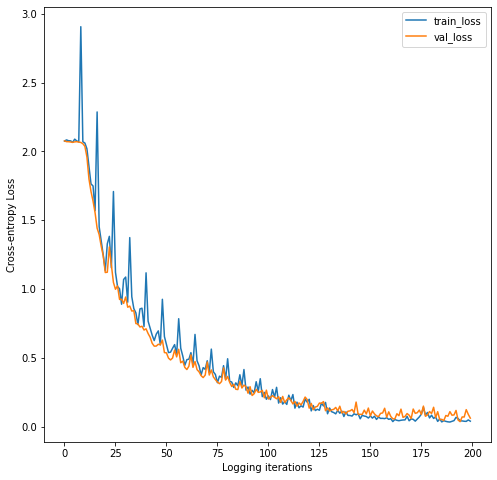

In [75]:
# TASK 6 CODE HERE [2 marks]
### BEGIN ANSWER ###
# You can do whatever you would like to plot results as long as it makes sense.

#loss curves
fig = plt.figure(figsize=(8,8))
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.xlabel("Logging iterations")
plt.ylabel("Cross-entropy Loss")
plt.legend()
plt.show()

### END ANSWER ###

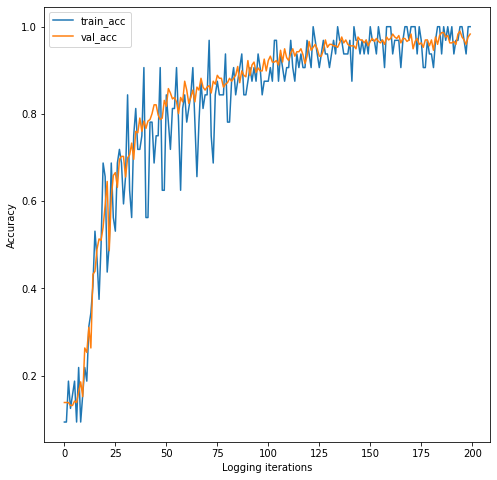

In [76]:
#Validation loss
fig = plt.figure(figsize=(8,8))
plt.plot(history['train_acc'], label='train_acc')
plt.plot(history['val_acc'], label='val_acc')
plt.xlabel("Logging iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Question [4 marks]:
Evaluate your results e.g. what can you tell from the training curves, is it performing well, do you think it would generalise to unseen data?


### Answer:
It is evident the model has performed well in unseen data sets. The results of comparing the seen tp unseen data are of high accuracy and show little deviation.

It would genralise well to unseen data.

# Task 7: Analysing the Confusion Matrix [3 marks]
Some code has been provided below to create a confusion matrix. The only thing you need to change is the appropriate data loader to create the confusion matrix from. 

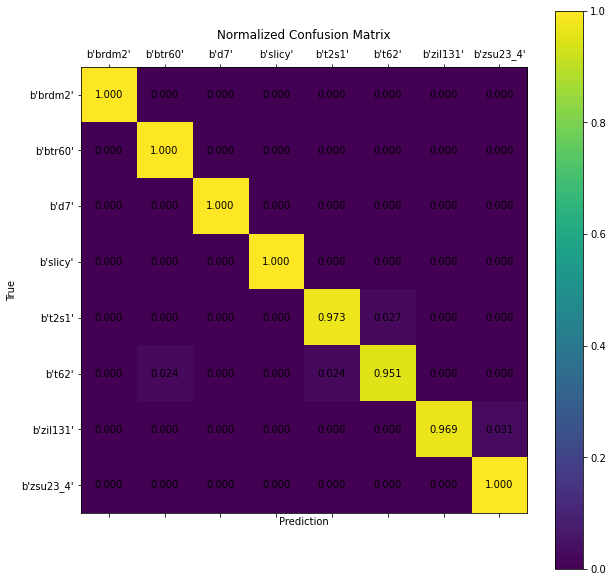

In [77]:
# TASK 7 CODE HERE [1 mark]

from sklearn.metrics import confusion_matrix

### BEGIN ANSWER ###

# change `loader` to whatever data loader you created you think is appropriate
it = iter(val_loader) 

### END ANSWER ###
x, y = next(it)

outputs = model(x)
_, y_pred = torch.max(outputs, 1)

np.set_printoptions(precision=4)
plt.figure(figsize = (10,10))
cm = confusion_matrix(y.numpy(), y_pred.numpy(), normalize="true")
plt.matshow(cm, fignum=1)

for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, '{:0.3f}'.format(z), ha='center', va='center')
    
plt.xticks(range(8))
plt.yticks(range(8))
plt.xlabel("Prediction")
plt.ylabel("True")

# We can retrieve the categories used by the LabelEncoder
classes = val_dataset.enc.classes_.tolist()
plt.gca().set_xticklabels(classes)
plt.gca().set_yticklabels(classes)

plt.title("Normalized Confusion Matrix")
plt.colorbar()
plt.show()

### Question [2 marks]:
Analyse the confusion matrix. e.g. are there any misclassified targets? If so, do they at least make some sense based on your understanding of what the targets are?

### Answer:
Yes, b't62' b't62',b'zil131. They make sense as some pictures do look similar.

# END OF PART 2